In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import csv
from datetime import datetime
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Models Estimation

In [44]:
path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/ecoflex_181221_rf_rd_data/'
path1 = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/x_y_data_all_points/'
train_path = '/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/percep_fbl_rf_rd_seperately_data/'
print(len(sorted(os.listdir(train_path))))
rnd_idx = np.array([2,8,27,32,33,97,104,105,109,116,131,136,143,148,154,158,164,170,186,199])

40


In [45]:
arr = np.array(pd.read_csv(path1+f'{rnd_idx[0]}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2]
arr.shape

(27234, 2)

In [46]:
y = np.array(pd.read_csv(train_path+f'{rnd_idx[0]}_percep_force_ecoflex_181221_data.csv'))
x2 = np.array(pd.read_csv(train_path+f'{rnd_idx[0]}_percep_pos_ecoflex_181221_data.csv'))
l = len(y)
x2.shape, y.shape

((1520, 10), (1520, 1))

In [47]:
kd = np.array(pd.read_csv('/content/drive/MyDrive/Virtual env/z_inhomogenous_modeling/KD_data.csv'))
ar = np.array([list(kd[rnd_idx[0]-1])]*l)
ar.shape

(1520, 2)

In [48]:
x = np.concatenate([x2,arr[:l,:],ar], axis = 1)
x.shape

(1520, 14)

In [49]:
for i in range(len(rnd_idx)-1):
    x1 = np.array(pd.read_csv(train_path+f'{rnd_idx[i+1]}_percep_pos_ecoflex_181221_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(train_path+f'{rnd_idx[i+1]}_percep_force_ecoflex_181221_data.csv'))
    l = len(y1)
    arr = np.array(pd.read_csv(path1+f'{rnd_idx[i+1]}_x_y_pos_vel_ecoflex_181221_data.csv'))[:l,:2] # x and y values
    ar = np.array([list(kd[rnd_idx[i+1]-1])]*l) # K and D values
    x2 = np.concatenate([x1,arr,ar], axis = 1)
    x = np.concatenate([x,x2])
    y = np.concatenate([y,y1])
print(x.shape, y.shape)

(28928, 14) (28928, 1)


In [55]:
y_test = np.array(pd.read_csv(path+f'{rnd_idx[0]-1}_force_ecoflex_181221_derivative_data.csv'))
x_t1 = np.array(pd.read_csv(path+f'{rnd_idx[0]-1}_pos_ecoflex_181221_derivative_data.csv'))
arr = np.array(pd.read_csv(path1+f'{rnd_idx[0]-1}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2]
ar = np.array([list(kd[rnd_idx[0]-2])]*len(x_t1))
x_test = np.concatenate([x_t1,arr,ar], axis = 1)

x_test.shape, y_test.shape

((27237, 14), (27237, 1))

In [56]:
for i in range(len(rnd_idx)//2):
    arr = np.array(pd.read_csv(path1+f'{rnd_idx[i+1]-1}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]-1}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{rnd_idx[i+1]-1}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[rnd_idx[i+1]-2])]*len(y1))
    x2 = np.concatenate([x1,arr,ar], axis = 1)
    x_test = np.concatenate([x_test,x2])
    y_test = np.concatenate([y_test,y1])
print(x_test.shape, y_test.shape)

(299599, 14) (299599, 1)


In [ ]:
cat = CatBoostRegressor()
t1 = datetime.now()
cat.fit(x,y)
t2 = datetime.now()
y_pred = cat.predict(x_test)

In [58]:
print('RMSE:', mean_squared_error(y_pred, y_test)**0.5)
print(t2-t1)

RMSE: 0.3931781698632256
0:00:10.714594


In [59]:
for i in range(74,82):
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[i-1])]*len(y1))
    x2 = np.concatenate([x1,arr, ar], axis = 1)
    y_pred = cat.predict(x2)
    print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')

For point: 74, Error: 0.5187946194177204
For point: 75, Error: 0.309790737858857
For point: 76, Error: 0.3573230923252336
For point: 77, Error: 0.20733394798424307
For point: 78, Error: 0.3632131584732766
For point: 79, Error: 0.6411062942110692
For point: 80, Error: 0.3383149194627558
For point: 81, Error: 0.3386099810727889


In [60]:
error = []
for i in range(1,201):
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[i-1])]*len(y1))
    x2 = np.concatenate([x1,arr, ar], axis = 1)
    y_pred = cat.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('resuts.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))

0.33104307750252154


In [61]:
max(error), min(error)

(1.1124319119797366, 0.07139940236080235)

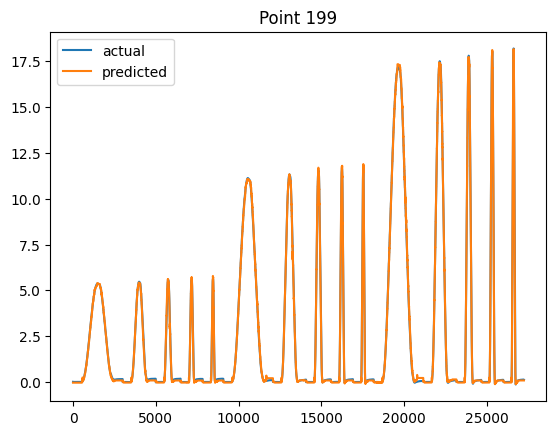

In [63]:
def graph(i):
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[i-1])]*len(y1))
    x2 = np.concatenate([x1,arr, ar], axis = 1)
    y_pred = cat.predict(x2)
    plt.plot(range(len(y1)), y1, label = 'actual')
    plt.plot(range(len(y1)), y_pred, label = 'predicted')
    plt.legend()
    plt.title(f'Point {i}')
    plt.show()

graph(199)

# Random Forest

In [64]:
rf = RandomForestRegressor()
t1 = datetime.now()
rf.fit(x,y)
t2 = datetime.now()
y_pred = rf.predict(x_test)
print('RMSE:', mean_squared_error(y_pred, y_test)**0.5)
print(t2-t1)

RMSE: 0.37577875533027255
0:00:36.523250


In [65]:
for i in range(74,82):
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[i-1])]*len(y1))
    x2 = np.concatenate([x1,arr, ar], axis = 1)
    y_pred = rf.predict(x2)
    print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')

For point: 74, Error: 0.649835361266901
For point: 75, Error: 0.15114617259951107
For point: 76, Error: 0.5124807807101445
For point: 77, Error: 0.19884998926887865
For point: 78, Error: 0.1887681120705782
For point: 79, Error: 0.3377284304144955
For point: 80, Error: 0.44430789069506804
For point: 81, Error: 0.21160526617568087


In [66]:
error = []
for i in range(1,201):
    arr = np.array(pd.read_csv(path1+f'{i}_x_y_pos_vel_ecoflex_181221_data.csv'))[:,:2] # x and y values
    x1 = np.array(pd.read_csv(path+f'{i}_pos_ecoflex_181221_derivative_data.csv')) # fractional derivatives
    y1 = np.array(pd.read_csv(path+f'{i}_force_ecoflex_181221_derivative_data.csv'))
    ar = np.array([list(kd[i-1])]*len(y1))
    x2 = np.concatenate([x1,arr, ar], axis = 1)
    y_pred = rf.predict(x2)
    statement = f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}\n'
    #print(f'For point: {i}, Error: {mean_squared_error(y_pred, y1)**0.5}')
    error.append(mean_squared_error(y_pred, y1)**0.5)
    with open('results.txt','a') as f:
        f.write(statement)
print(sum(error)/len(error))

0.3283248817718604


In [67]:
max(error), min(error)

(1.2975884631804728, 0.07351974400710372)